# Automated Statistical Analysis and Plotting

Github: https://github.com/mitmedialab/AI-generated-characters

*This notebook is an automated pipeline for determining appropriate statistical tests and plotting results with barcharts. To determine the proper test, the pipeline first tests whether the normality assumption is met for each distribution using the Shapiro-Wilk test. If the normality assumption is not met, it then performs a Kruskal-Wallis test followed by a post-hoc Dunn test with Bonferonni correction. If the normality assumption is met, it tests homogeneity using a Levene test to assess whether the samples were from populations with equal variances. If the samples are not homogeneous, it then runs a Welch analysis of variance (ANOVA Welch), and post-hoc evaluation using Tukey post-hoc test. If the samples are homogeneous it runs a basic ANOVA test. The overall flow of the pipeline can be observed in the image below.*

![](https://drive.google.com/uc?export=view&id=1Xa7X3NPF83RV1mfJQGdXmn_-Jz8g8uG5)

**Licensed under the MIT License**


Copyright (c) 2022 MIT Media Lab

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

# Analyse data

In [44]:
#@markdown Install libraries

!pip install 'pingouin==0.5.2'
!pip install 'scikit-posthocs == 0.7.0'
!pip install 'statannotations == 0.4.4'

from IPython.display import clear_output 
clear_output()

import itertools
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prerun_stats (sample_keys, group_label, data, y, stats_viz=False):

  ## Stats
  import scipy.stats as stats
  from pingouin import welch_anova, pairwise_gameshowell, pairwise_tukey
  from statistics import stdev
  import numpy as np
  
  MIN_SAMPLE_SIZE = 25
  TOLERANCE = 0.15

  sample_data = [data.copy().apply(lambda z: z[y] if z[group_label] == key else None, axis=1).dropna() for key in sample_keys]
  #sample_data = [data[data[group_label]==key][y] for key in sample_keys]


  sample_data_w_keys = pd.concat([pd.DataFrame({y:data.values, group_label:sample_keys[i]}) for i, data in enumerate(sample_data.copy())], axis=0, ignore_index=True)
  
  if stats_viz is True:
    print(f"Running stats between the samples: {sample_keys}")

  # Means for each sample group
  means_table = data[group_label].value_counts()

  # Check if *all* data points for each sample group are over 25
  sample_sizes_sufficient = all([sample > MIN_SAMPLE_SIZE for sample in means_table])

  # Check if means are equal within the TOLERANCE for each sample group
  sample_sizes_equal = all([abs(sample1 - sample2) < np.mean(means_table) * TOLERANCE for sample1, sample2 in itertools.combinations(means_table, 2)])

  # Dunn Test
  dunn = sp.posthoc_dunn(sample_data, p_adjust='bonferroni')
  replacer = {i+1:key for i, key in enumerate(sample_keys)}
  dunn.rename(columns = replacer, index=replacer, inplace=True)

  # Compile all stats into list
  statz = {'sample_sizes_sufficient': sample_sizes_sufficient,
          'sample_sizes_equal':      sample_sizes_equal,
          'shapiro':                 stats.shapiro(data[y]),
          'levene':                  stats.levene(*sample_data),
          'f_oneway':                stats.f_oneway(*sample_data),
          'kruskal':                 stats.kruskal(*sample_data),
          'welch_anova':             welch_anova(dv=y, between=group_label, data=sample_data_w_keys),
          'gameshowell':             pairwise_gameshowell(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'tukey':                   pairwise_tukey(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'dunn':                    dunn,
          'mean_std':                {key:{'mean' : np.mean(population), \
                                           'std' : stats.tstd(population)} for key, population in zip(sample_keys, sample_data)},
  }

  return statz



def stats_tree(sample_keys, sample_sizes_sufficient, sample_sizes_equal, shapiro, levene, f_oneway, kruskal, welch_anova, gameshowell, tukey, dunn, mean_std=None, stats_viz=False):

  import itertools

  ALPHA = 0.05
  indent = '   '


  if sample_sizes_sufficient or shapiro.pvalue > ALPHA:
    if stats_viz is True:
      print("> Sample size sufficient" if sample_sizes_sufficient else f">Sample size insufficient but *normality is met*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if sample_sizes_equal or levene.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes equal" if sample_sizes_equal else f"{indent*1}>Sample sizes not equal but *homogeneity is met*: s_levene={levene.statistic}, p_levene={levene.pvalue}")

      if f_oneway.pvalue < ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA (f_oneway) *significant*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}")
          print(f"\n> Thus running Tukey Test:")
          print(tukey)
          print(f"mean_std: {mean_std}")

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()
        
        return pairs, p_values

      elif f_oneway.pvalue > ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}" if stats_viz is True else "")
          print(f"mean_std: {mean_std}" )

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()

        return pairs, p_values

    elif not sample_sizes_equal or levene.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes are unequal and homogeneity *NOT MET*: w_levene={levene.statistic}, p_levene={levene.pvalue}")

      if welch_anova['p-unc'][0] < ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *SIGNIFICANT*: welch=\n{welch_anova}")#{welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"\n>Thus running Games-Howell test:")
          print(gameshowell)
          print(f"mean_std: {mean_std}")
        
        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

      elif welch_anova['p-unc'][0] > ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *NOT SIGNIFICANT*: welch=\n{welch_anova}")#F_welch={welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"mean_std: {mean_std}")

        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

  elif not sample_sizes_sufficient or shapiro.pvalue < ALPHA:
    if stats_viz is True:
      print(f"{indent*1}> Both minimum sample size and normality were *NOT MET*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if kruskal.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n Kruskal Wallis *SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"{indent*2}> Running DUNN test:")
        print(dunn)
        print(f"mean_std: {mean_std}")
      
      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values

    elif kruskal.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n{indent*3}>Kruskal Wallis *NOT SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"mean_std: {mean_std}")
      
      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values


def plot_stats(pairs, p_values, y, x, hue=None, figsize=[4,8], ylim=None, **kwgs):

  from statannotations.Annotator import Annotator

  if figsize is None and hue is not None:
    figsize = [data[x].nunique()*data[hue].nunique()*1.2, 8]
  elif figsize is None and hue is None:
    figsize = [data[x].nunique()*1.2, 8]

  # plot 
  fig, ax = plt.subplots(figsize=figsize)
  plt.tight_layout()
  sns.barplot(ax=ax, **plot_params)
  annot = Annotator(ax, pairs, **plot_params)
  annot.configure(text_format="star", loc="inside")
  annot.set_pvalues_and_annotate(p_values)

  # styling
  #ax.text(x=0.5, y=-0.3, s=lbl, fontsize=10, ha='center', va='bottom', transform=ax.transAxes)

  ax.set_title(f"{y} for {x}")
  if hue is not None:
    ax.set_title(f"{y} for {x} by {hue.lower()}")

  if ylim is not None:
    ax.set_ylim(ylim)

  plt.show()


def stats(data, y, x, hue=None, graph_viz=True, stats_viz=False, ylim=None, figsize=None, **kwgs):

  target_data = [data] # The data to be used for statistical analysis
  target_label = x # The column name with the groups to be compared between
  within_sample = [None] # The value of a column for hue groups to be compared within 

  if hue is not None:

    within_sample = data[x].unique()
    target_data = [data[data[x]==group] for group in within_sample]
    target_label = hue

  pairs = []
  p_values = []

  for i, data in enumerate(target_data):
    
    if stats_viz is True:
      print(f"----\nWithin the '{within_sample[i]}' group of '{x}':\n----" if len(within_sample) > 1 else "----")

    sample_keys = [key for key in data[target_label].unique()]
    stat_results = prerun_stats (sample_keys, target_label, data, y, stats_viz=stats_viz)
    pair, p_value = stats_tree(sample_keys, **stat_results, stats_viz=stats_viz)

    for pair_item, p_value_item in zip(pair, p_value):
      if hue is not None:
        pair_item = [pair_w_sample_label for pair_w_sample_label in itertools.product([within_sample[i]],pair_item)]
      pairs.append(pair_item)
      p_values.append(p_value_item)
    print("----" if stats_viz is True else "")

  if graph_viz:
    plot_stats(pairs, p_values, ylim=ylim, figsize=figsize, **plot_params)

print("Installation Complete")

Installation Complete


In [97]:
# Example Dataset
example = sns.load_dataset("titanic")
data = pd.DataFrame(example)

# General Settings
palette = ["tomato", "cornflowerblue"] # <-- complete list of colors can be found at "https://matplotlib.org/stable/gallery/color/named_colors.html"

In [98]:
# Preview data
data.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True





p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Second_female vs. Second_male: Custom statistical test, P_val:0.000e+00
First_female vs. First_male: Custom statistical test, P_val:0.000e+00
Third_female vs. Third_male: Custom statistical test, P_val:0.000e+00


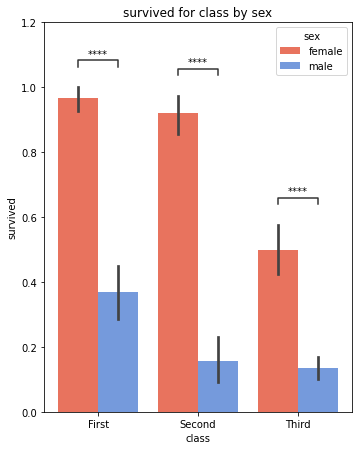

In [106]:
# Plot

# Plot settings
plot_params = {
    'x': "class",
    'y' : "survived",
    'hue' : 'sex',
    'data' : data,
    'palette': palette,
    'order' : ['First', 'Second', 'Third'],
    'hue_order' : ['female', 'male'],
}

# Stats
stats(**plot_params, graph_viz=True, ylim=[0,1.2], figsize=[5,6], stats_viz=False)